# 四分类肺部CT模型（带掩膜可视化）
**任务说明**：
- 1.四分类（COVID/Lung_Opacity/Normal/Viral Pneumonia）
- 2.肺部区域掩膜生成
- 3.在分类结果旁叠加显示预测掩膜

In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms.functional import rotate, hflip
from segmentation_models_pytorch import UnetPlusPlus
from sklearn.model_selection import train_test_split
import cv2
from PIL import Image

## 1. 多任务数据集（图像+类别+掩膜）
**每个样本包含图像、类别标签和掩膜**

In [2]:
class MultiTaskDataset(Dataset):
    def __init__(self, image_paths, mask_paths, labels, transform=None, augment=False):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.labels = labels
        self.transform = transform
        self.augment = augment

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # 加载图像
        image = Image.open(self.image_paths[idx]).convert("RGB")
        image = image.resize((256, 256))

        # 加载掩膜
        mask = Image.open(self.mask_paths[idx]).convert("L")
        mask = np.array(mask) > 127  # 二值化
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)  # (1, H, W)

        # 加载类别标签
        label = self.labels[idx]

        # 数据增强
        if self.augment:
            if np.random.random() > 0.5:
                image = hflip(image)
                mask = torch.flip(mask, dims=[2])
            if np.random.random() > 0.5:
                angle = np.random.uniform(-15, 15)
                image = rotate(image, angle)
                mask = rotate(mask, angle)

        # 转换为张量
        image = transforms.ToTensor()(image)
        image = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image)

        return image, mask, label

In [3]:
def load_multi_task_dataset(data_root, num_per_class=50):
    class_map = {
        "COVID": (0, "COVID"),
        "Lung_Opacity": (1, "Lung_Opacity"),
        "Normal": (2, "Normal"),
        "Viral Pneumonia": (3, "Viral Pneumonia")
    }

    image_paths = []
    mask_paths = []
    labels = []

    for class_name, (label, _) in class_map.items():
        image_dir = os.path.join(data_root, class_name, "images")
        mask_dir = os.path.join(data_root, class_name, "masks")

        class_images = sorted(glob(os.path.join(image_dir, "*.png")))[:num_per_class]
        class_masks = sorted(glob(os.path.join(mask_dir, "*.png")))[:num_per_class]

        image_paths.extend(class_images)
        mask_paths.extend(class_masks)
        labels.extend([label] * len(class_images))

    return image_paths, mask_paths, labels

## 2. 多任务模型（分类+分割）
**U-Net++主干 + 分类头 + 分割头**

In [4]:
class MultiTaskModel(nn.Module):
    def __init__(self, num_classes=4):
        super(MultiTaskModel, self).__init__()
        # 分割主干（U-Net++）
        self.segmentation_backbone = UnetPlusPlus(
            encoder_name="resnet34",
            encoder_weights="imagenet",
            in_channels=3,
            classes=1,
            activation="sigmoid"
        )

        # 分类头（基于主干特征）
        self.classification_head = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        # 分割分支
        seg_output = self.segmentation_backbone(x)  # (B, 1, H, W)

        # 分类分支（使用主干的中间特征）
        class_feat = self.segmentation_backbone.encoder(x)[-1]  # 使用编码器最后一层特征
        class_output = self.classification_head(class_feat)

        return seg_output, class_output

## 3. 多任务损失函数
**分割损失（Dice） + 分类损失（CrossEntropy）**

In [5]:
class MultiTaskLoss(nn.Module):
    def __init__(self, seg_weight=1.0, cls_weight=1.0):
        super(MultiTaskLoss, self).__init__()
        self.seg_loss = nn.BCELoss()
        self.cls_loss = nn.CrossEntropyLoss()
        self.seg_weight = seg_weight
        self.cls_weight = cls_weight

    def forward(self, seg_pred, cls_pred, seg_target, cls_target):
        seg_loss = self.seg_loss(seg_pred, seg_target)
        cls_loss = self.cls_loss(cls_pred, cls_target)
        total_loss = self.seg_weight * seg_loss + self.cls_weight * cls_loss
        return total_loss, seg_loss, cls_loss

## 4. 训练流程
**同时优化分类和分割任务**

In [8]:
import matplotlib.pyplot as plt
from IPython.display import clear_output  # 用于实时更新图表

def train_multi_task_model(
    model, 
    train_loader, 
    val_loader, 
    criterion, 
    optimizer, 
    scheduler=None, 
    num_epochs=20,
    num_per_class=30,
    plot_training=True  # 控制是否绘制训练过程图表
):
    """
    训练多任务模型（分类+分割），支持小样本和完整数据模式
    """
    device = next(model.parameters()).device
    best_cls_acc = 0.0
    
    # 记录训练历史
    history = {
        'train_total_loss': [], 'train_seg_loss': [], 'train_cls_loss': [], 'train_cls_acc': [],
        'val_seg_loss': [], 'val_cls_loss': [], 'val_cls_acc': []
    }
    
    # 生成模型保存路径
    use_full_data = (num_per_class == -1)
    total_samples = len(train_loader.dataset) + len(val_loader.dataset)
    if use_full_data:
        save_path = "full_data_best_model.pth"
    else:
        save_path = f"small_sample_{total_samples}samples_{num_epochs}epochs.pth"
    
    plt.figure(figsize=(12, 10))  # 创建图表
    
    for epoch in range(num_epochs):
        # 训练阶段
        model.train()
        running_total_loss = 0.0
        running_seg_loss = 0.0
        running_cls_loss = 0.0
        running_cls_correct = 0
        
        for images, masks, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
            images = images.to(device)
            masks = masks.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            seg_pred, cls_pred = model(images)
            total_loss, seg_loss, cls_loss = criterion(seg_pred, cls_pred, masks, labels)
            
            total_loss.backward()
            optimizer.step()
            
            running_total_loss += total_loss.item() * images.size(0)
            running_seg_loss += seg_loss.item() * images.size(0)
            running_cls_loss += cls_loss.item() * images.size(0)
            running_cls_correct += (cls_pred.argmax(dim=1) == labels).sum().item()
        
        # 验证阶段
        model.eval()
        val_seg_loss = 0.0
        val_cls_loss = 0.0
        val_cls_correct = 0
        val_total_samples = 0
        
        with torch.no_grad():
            for images, masks, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
                images = images.to(device)
                masks = masks.to(device)
                labels = labels.to(device)
                
                seg_pred, cls_pred = model(images)
                total_loss, seg_loss, cls_loss = criterion(seg_pred, cls_pred, masks, labels)
                
                val_seg_loss += seg_loss.item() * images.size(0)
                val_cls_loss += cls_loss.item() * images.size(0)
                val_cls_correct += (cls_pred.argmax(dim=1) == labels).sum().item()
                val_total_samples += len(labels)
        
        # 计算指标
        train_total_loss = running_total_loss / len(train_loader.dataset)
        train_seg_loss = running_seg_loss / len(train_loader.dataset)
        train_cls_loss = running_cls_loss / len(train_loader.dataset)
        train_cls_acc = running_cls_correct / len(train_loader.dataset)
        
        val_seg_loss = val_seg_loss / len(val_loader.dataset)
        val_cls_loss = val_cls_loss / len(val_loader.dataset)
        val_cls_acc = val_cls_correct / val_total_samples
        val_total_loss = val_seg_loss + val_cls_loss
        
        # 记录历史
        history['train_total_loss'].append(train_total_loss)
        history['train_seg_loss'].append(train_seg_loss)
        history['train_cls_loss'].append(train_cls_loss)
        history['train_cls_acc'].append(train_cls_acc)
        history['val_seg_loss'].append(val_seg_loss)
        history['val_cls_loss'].append(val_cls_loss)
        history['val_cls_acc'].append(val_cls_acc)
        
        # 打印指标
        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {train_total_loss:.4f} | "
              f"Seg Loss: {train_seg_loss:.4f} | Cls Loss: {train_cls_loss:.4f} | Cls Acc: {train_cls_acc:.4f} | "
              f"Val Seg Loss: {val_seg_loss:.4f} | Val Cls Loss: {val_cls_loss:.4f} | Val Cls Acc: {val_cls_acc:.4f}")
        
        # 更新学习率调度器
        if scheduler is not None:
            scheduler.step(val_total_loss)
        
        # 保存最佳模型
        if val_cls_acc > best_cls_acc:
            best_cls_acc = val_cls_acc
            torch.save(model.state_dict(), save_path)
            print(f"✨ Best Model Updated | Path: {save_path} | Accuracy: {best_cls_acc:.4f}")
        
        # 绘制训练过程图表
        if plot_training:
            clear_output(wait=True)
            plt.figure(figsize=(12, 10))
            
            # 绘制总损失
            plt.subplot(2, 2, 1)
            plt.plot(history['train_total_loss'], label='Train Total Loss')
            plt.plot([s + c for s, c in zip(history['val_seg_loss'], history['val_cls_loss'])], label='Val Total Loss')
            plt.title('Total Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            plt.grid(True)
            
            # 绘制分割损失
            plt.subplot(2, 2, 2)
            plt.plot(history['train_seg_loss'], label='Train Seg Loss')
            plt.plot(history['val_seg_loss'], label='Val Seg Loss')
            plt.title('Segmentation Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            plt.grid(True)
            
            # 绘制分类损失
            plt.subplot(2, 2, 3)
            plt.plot(history['train_cls_loss'], label='Train Cls Loss')
            plt.plot(history['val_cls_loss'], label='Val Cls Loss')
            plt.title('Classification Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            plt.grid(True)
            
            # 绘制分类准确率
            plt.subplot(2, 2, 4)
            plt.plot(history['train_cls_acc'], label='Train Cls Acc')
            plt.plot(history['val_cls_acc'], label='Val Cls Acc')
            plt.title('Classification Accuracy')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.legend()
            plt.grid(True)
            
            plt.tight_layout()
            plt.show()
    
    print(f"Training complete. Best accuracy: {best_cls_acc:.4f}")
    return model, history  # 返回训练历史

## 5. 主训练流程
**（小样本模式）每个类别取30样本，同时训练分类和分割**

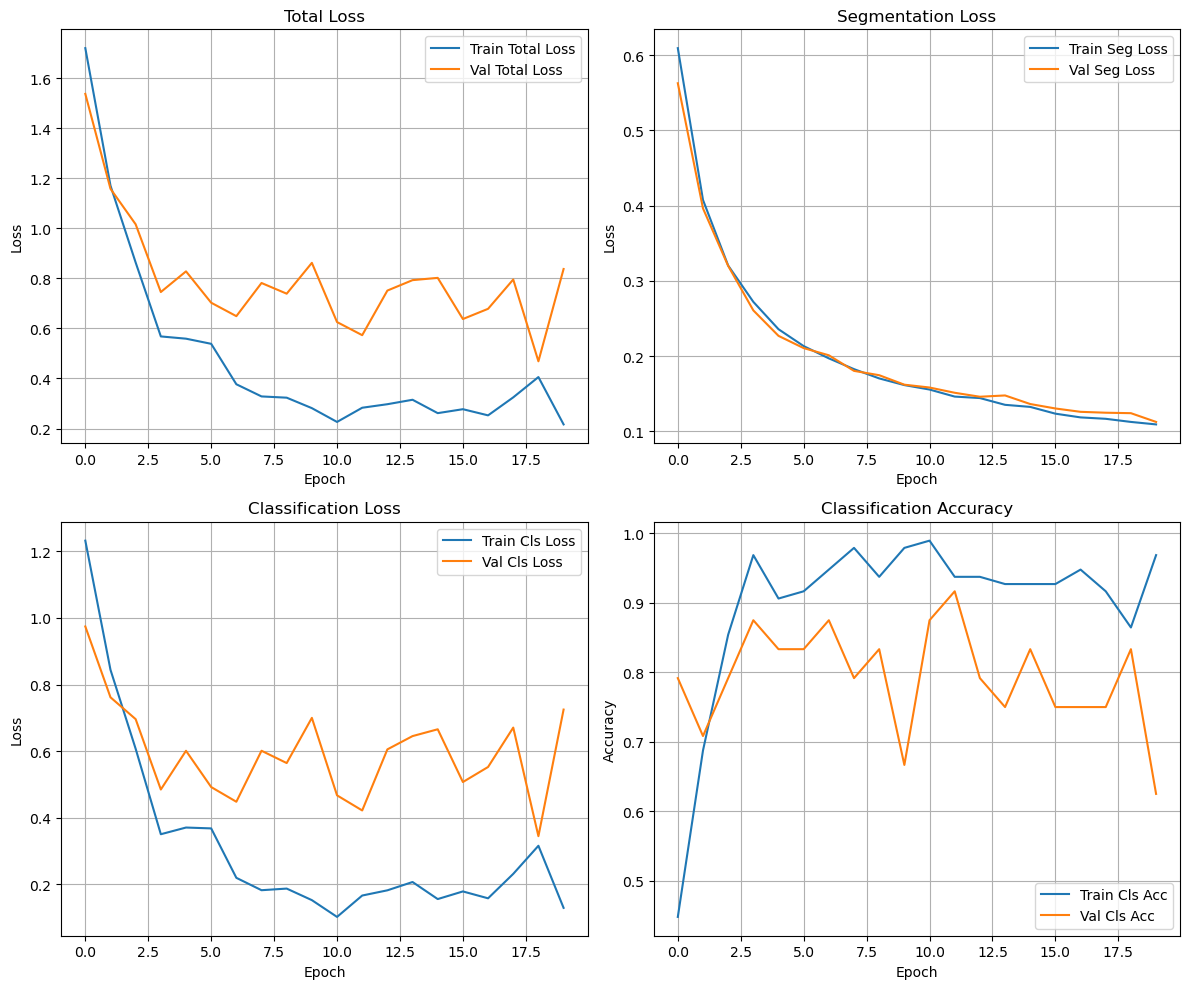

Training complete. Best accuracy: 0.9167


In [15]:
# 小样本模式配置（无需调度器）
data_root = "COVID-19_Radiography_Dataset"
num_per_class = 30
batch_size = 8
num_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 加载数据并创建数据加载器
image_paths, mask_paths, labels = load_multi_task_dataset(data_root, num_per_class)
train_idx, val_idx = train_test_split(range(len(image_paths)), test_size=0.2, random_state=8)

# 创建数据集（修正参数传递）
train_data = MultiTaskDataset(
    [image_paths[i] for i in train_idx],
    [mask_paths[i] for i in train_idx],
    [labels[i] for i in train_idx],
    augment=True
)

val_data = MultiTaskDataset(
    [image_paths[i] for i in val_idx],
    [mask_paths[i] for i in val_idx],
    [labels[i] for i in val_idx],
    augment=False
)

# 创建数据加载器
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=0)

# 初始化模型和优化器（不使用调度器）
model = MultiTaskModel(num_classes=4).to(device)
criterion = MultiTaskLoss(seg_weight=0.8, cls_weight=1.0)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# 调用训练函数（scheduler=None），训练时启用可视化
trained_model, history = train_multi_task_model(
    model, train_loader, val_loader, criterion, optimizer,
    scheduler=None,
    num_epochs=num_epochs,
    plot_training=True  # 启用图表
)

<!-- **完整数据模式** -->

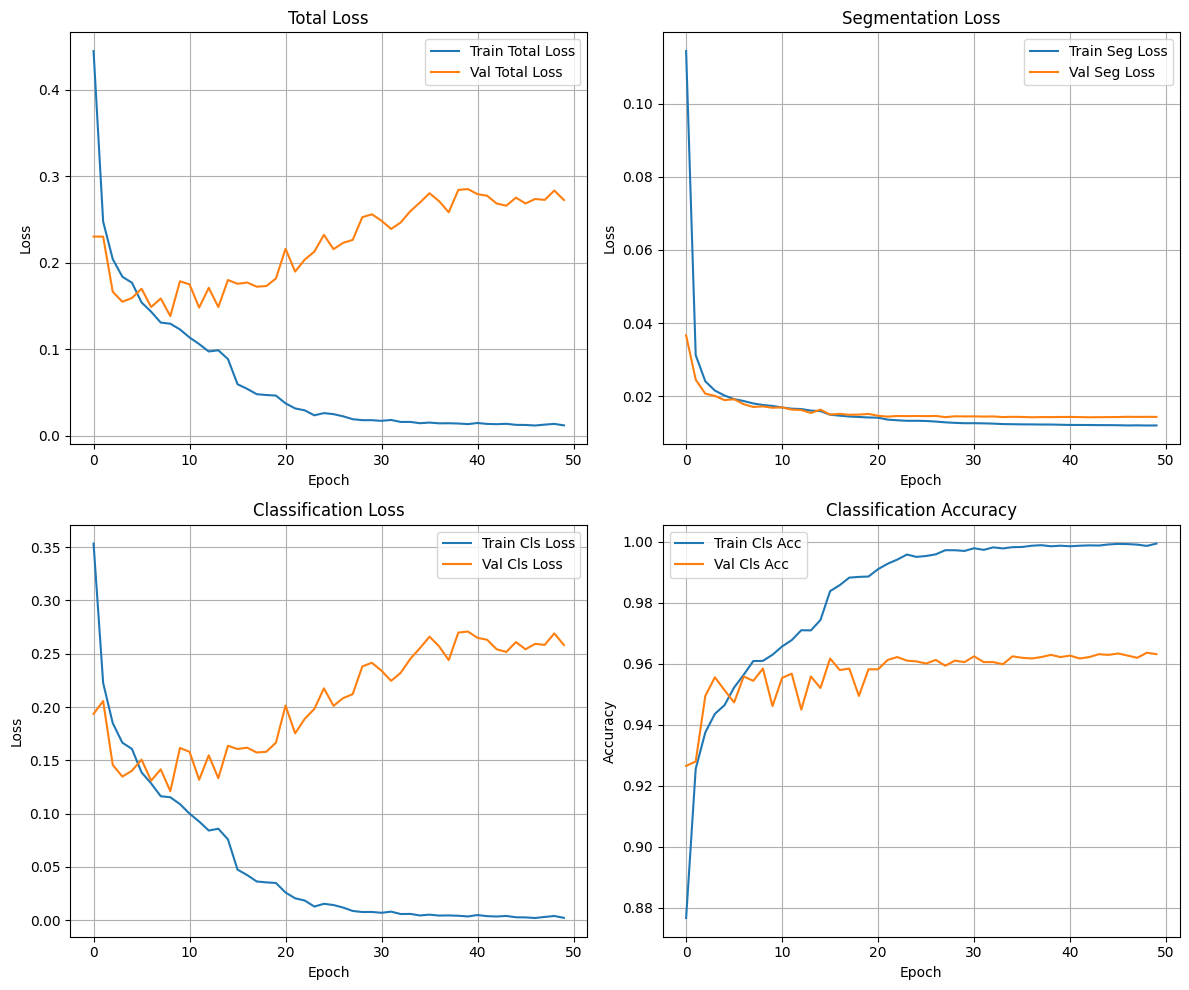

Training complete. Best accuracy: 0.9636


In [8]:
# 修改配置参数
data_root = "COVID-19_Radiography_Dataset"
num_per_class = -1  # 使用全量数据
batch_size = 16
num_epochs = 50  # 增加训练轮数
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 加载数据
image_paths, mask_paths, labels = load_multi_task_dataset(data_root, num_per_class)
train_idx, val_idx = train_test_split(range(len(image_paths)), test_size=0.2, random_state=8)

# 创建数据集（保持数据增强）
train_data = MultiTaskDataset(
    [image_paths[i] for i in train_idx],
    [mask_paths[i] for i in train_idx],
    [labels[i] for i in train_idx],
    augment=True
)

val_data = MultiTaskDataset(
    [image_paths[i] for i in val_idx],
    [mask_paths[i] for i in val_idx],
    [labels[i] for i in val_idx],
    augment=False
)

# 创建数据加载器
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=0)

# 初始化模型和优化器
model = MultiTaskModel(num_classes=4).to(device)
criterion = MultiTaskLoss(seg_weight=0.8, cls_weight=1.0)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# 添加学习率调度器（根据验证集总损失调整）
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',        # 目标是最小化验证损失
    factor=0.5,        # 学习率降低因子
    patience=5,        # 等待5个epoch无改善再调整
    verbose=True       # 打印学习率调整信息
)

# 调用训练函数（启用可视化并传递num_per_class参数）
trained_model, history = train_multi_task_model(
    model, train_loader, val_loader, criterion, optimizer,
    scheduler=scheduler,        # 使用学习率调度器
    num_epochs=num_epochs,      # 设置训练轮数
    num_per_class=num_per_class,  # 指定使用全量数据
    plot_training=True          # 启用训练过程可视化
)

## 6. 模型评估
**计算分类准确率和分割指标（Dice系数、IoU）**

In [9]:
def evaluate_model(model, dataloader, class_names, device=None):
    device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.eval().to(device)
    
    # 初始化指标
    class_correct = 0
    class_total = 0
    class_correct_by_class = {i: 0 for i in range(len(class_names))}
    class_total_by_class = {i: 0 for i in range(len(class_names))}
    
    seg_dice = 0.0
    seg_iou = 0.0
    seg_samples = 0
    
    with torch.no_grad():
        for images, masks, labels in tqdm(dataloader, desc="Evaluating"):
            images = images.to(device)
            masks = masks.to(device)
            labels = labels.to(device)
            
            # 预测
            seg_pred, cls_pred = model(images)
            
            # 分类指标
            _, predicted = torch.max(cls_pred, 1)
            class_total += labels.size(0)
            class_correct += (predicted == labels).sum().item()
            
            # 按类别统计
            for i in range(len(class_names)):
                class_mask = (labels == i)
                class_total_by_class[i] += class_mask.sum().item()
                class_correct_by_class[i] += (predicted[class_mask] == labels[class_mask]).sum().item()
            
            # 分割指标
            seg_binary = (seg_pred > 0.5).float()
            for i in range(seg_binary.size(0)):
                intersection = (seg_binary[i] * masks[i]).sum().item()
                union = (seg_binary[i] + masks[i]).sum().item()
                
                # 计算Dice系数
                dice = (2.0 * intersection) / (union + intersection + 1e-8)
                seg_dice += dice
                
                # 计算IoU
                iou = intersection / (union - intersection + 1e-8)
                seg_iou += iou
                
                seg_samples += 1
    
    # 计算总体分类准确率
    overall_accuracy = 100 * class_correct / class_total
    
    # 计算每个类别的准确率
    class_accuracies = {}
    for i, name in enumerate(class_names):
        class_acc = 100 * class_correct_by_class[i] / max(1, class_total_by_class[i])
        class_accuracies[name] = class_acc
        print(f"Class {name}: {class_correct_by_class[i]}/{class_total_by_class[i]} correct ({class_acc:.2f}%)")
    
    # 计算平均分割指标
    avg_dice = seg_dice / max(1, seg_samples)
    avg_iou = seg_iou / max(1, seg_samples)
    
    print(f"\nOverall Classification Accuracy: {overall_accuracy:.2f}%")
    print(f"Average Segmentation Dice: {avg_dice:.4f}")
    print(f"Average Segmentation IoU: {avg_iou:.4f}")
    
    return {
        "overall_accuracy": overall_accuracy,
        "class_accuracies": class_accuracies,
        "avg_dice": avg_dice,
        "avg_iou": avg_iou
    }

## 7. 运行评估并展示结果
**在验证集上评估模型性能**

Evaluating: 100%|██████████| 3/3 [00:00<00:00,  4.28it/s]


Class COVID: 5/5 correct (100.00%)
Class Lung_Opacity: 5/6 correct (83.33%)
Class Normal: 5/6 correct (83.33%)
Class Viral Pneumonia: 7/7 correct (100.00%)

Overall Classification Accuracy: 91.67%
Average Segmentation Dice: 0.6401
Average Segmentation IoU: 0.8931
Normalized confusion matrix


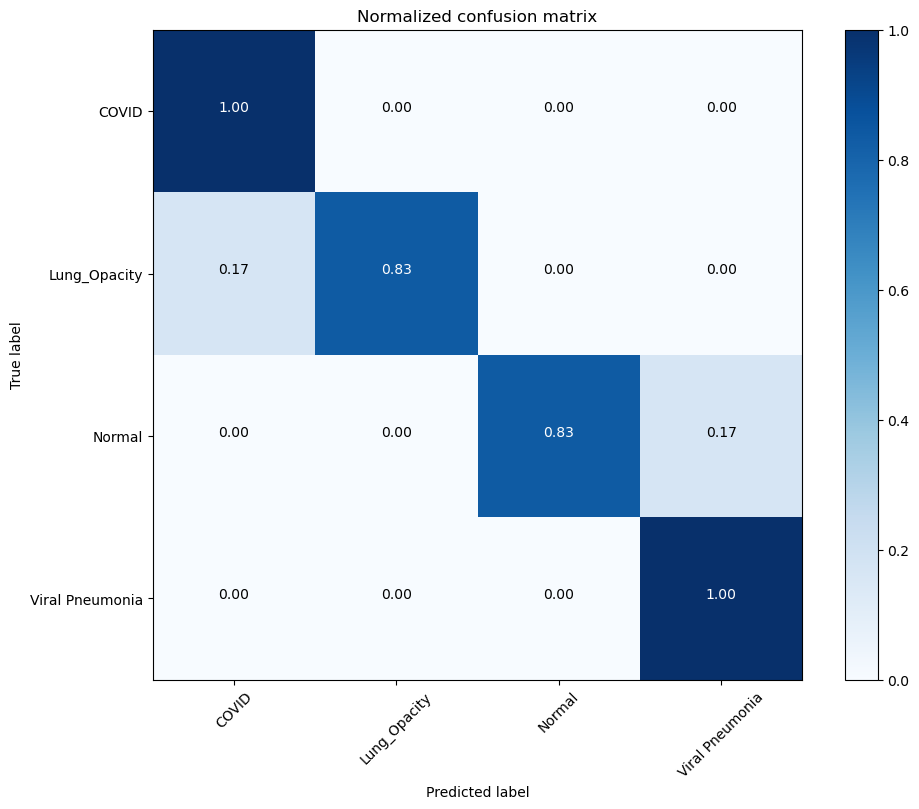

In [26]:
# 加载最佳模型
best_model = MultiTaskModel(num_classes=4).to(device)
best_model.load_state_dict(torch.load("small_sample_120samples_20epochs.pth"))

# 评估模型
class_names = ["COVID", "Lung_Opacity", "Normal", "Viral Pneumonia"]
metrics = evaluate_model(best_model, val_loader, class_names)

# 绘制混淆矩阵
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    此函数用于绘制混淆矩阵
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# 计算混淆矩阵
from sklearn.metrics import confusion_matrix
import itertools

y_true = []
y_pred = []

with torch.no_grad():
    for images, _, labels in val_loader:
        images = images.to(device)
        _, cls_pred = best_model(images)
        _, predicted = torch.max(cls_pred, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# 绘制混淆矩阵
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, classes=class_names, normalize=True, title='Normalized confusion matrix')

## 8. 预测与掩膜可视化
**同时输出分类结果和掩膜叠加图**

In [10]:
def visualize_predictions(model, image_path, mask_path=None, class_names=None, alpha=0.4, device=None):
    device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.eval().to(device)

    # 加载图像
    image = Image.open(image_path).convert("RGB")
    original_size = image.size
    image_np = np.array(image)
    input_tensor = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])(image).unsqueeze(0).to(device)

    # 预测
    with torch.no_grad(): 
        seg_pred, cls_pred = model(input_tensor)
        cls_label = cls_pred.argmax(dim=1).item()
        seg_mask = (seg_pred > 0.5).cpu().numpy()[0, 0]  # 二值化掩膜

    # 调整掩膜大小
    seg_mask = cv2.resize(seg_mask.astype(np.uint8), original_size)

    # 创建红色掩膜
    red_mask = np.zeros_like(image_np)
    red_mask[:, :, 0] = seg_mask * 255  # BGR格式下的红色
    overlay = cv2.addWeighted(image_np, 1, red_mask, alpha, 0)

    # 绘制结果
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(image_np)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(overlay)
    axes[1].set_title(f"Predicted Mask\nClass: {class_names[cls_label]}")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

## 9. 示例运行
**加载最佳模型并可视化预测结果**

In [28]:
class_names = ["COVID", "Lung_Opacity", "Normal", "Viral Pneumonia"]
best_model = MultiTaskModel(num_classes=4).to(device)
best_model.load_state_dict(torch.load("small_sample_120samples_20epochs.pth"))

<All keys matched successfully>

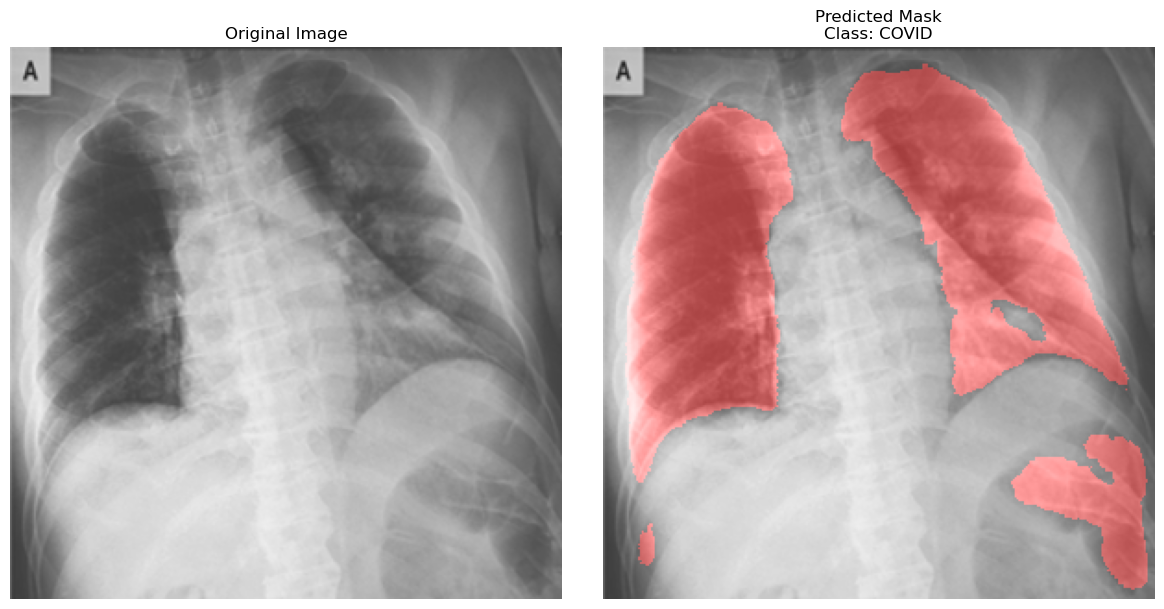

In [29]:
# 示例图像
test_image = "COVID-19_Radiography_Dataset/COVID/images/COVID-2.png"
visualize_predictions(best_model, test_image, class_names=class_names)

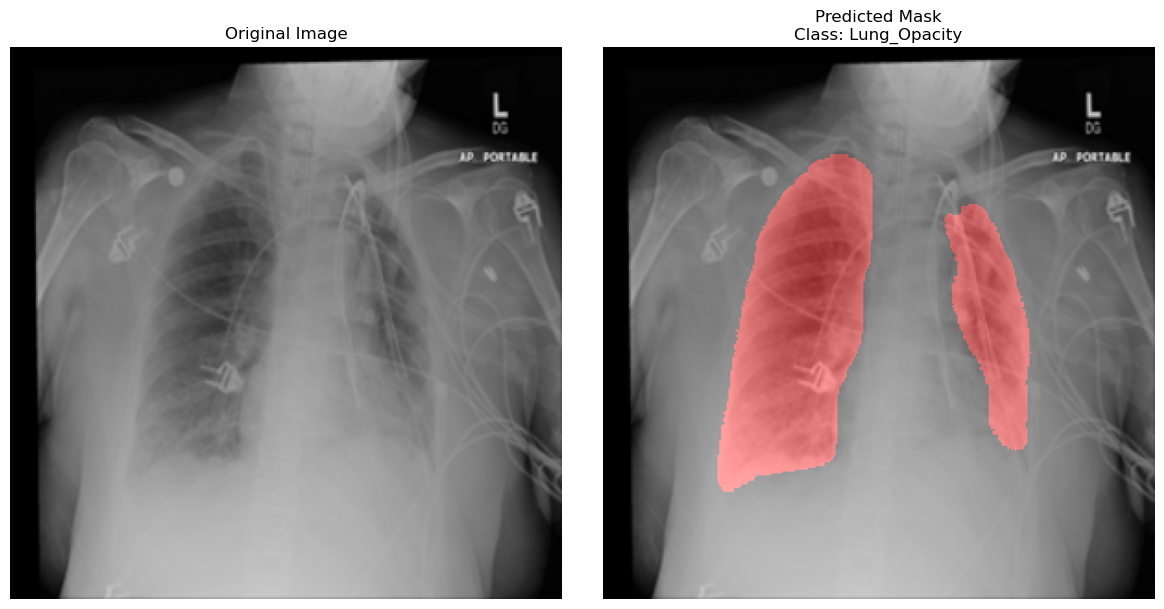

In [30]:
test_image = "COVID-19_Radiography_Dataset/Lung_Opacity/images/Lung_Opacity-2.png"
visualize_predictions(best_model, test_image, class_names=class_names)

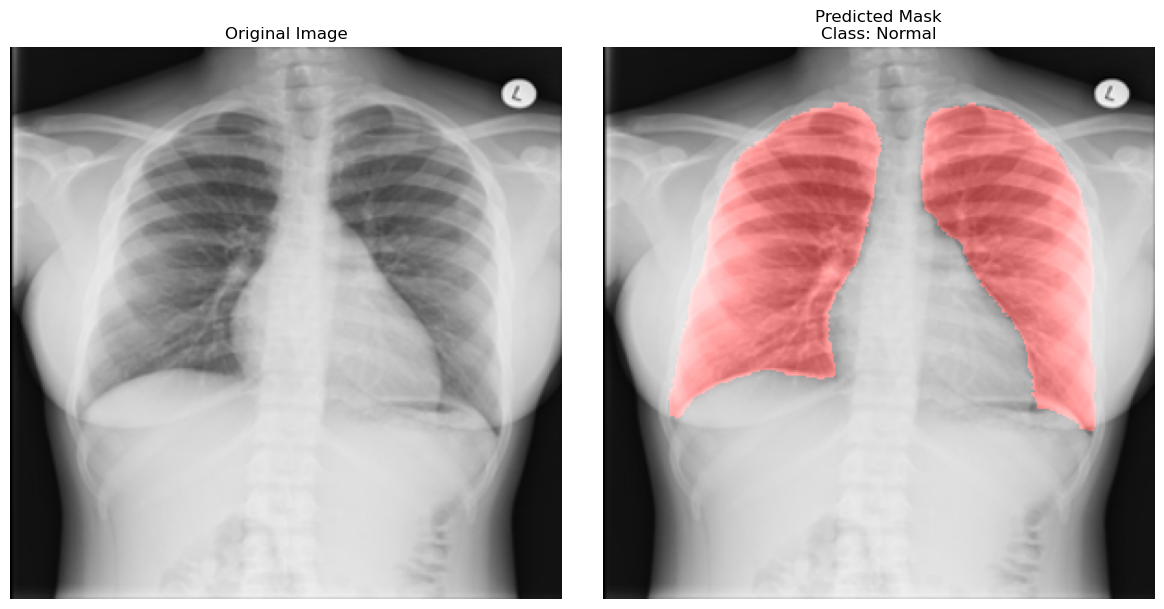

In [31]:
test_image = "COVID-19_Radiography_Dataset/Normal/images/Normal-2.png"
visualize_predictions(best_model, test_image, class_names=class_names)

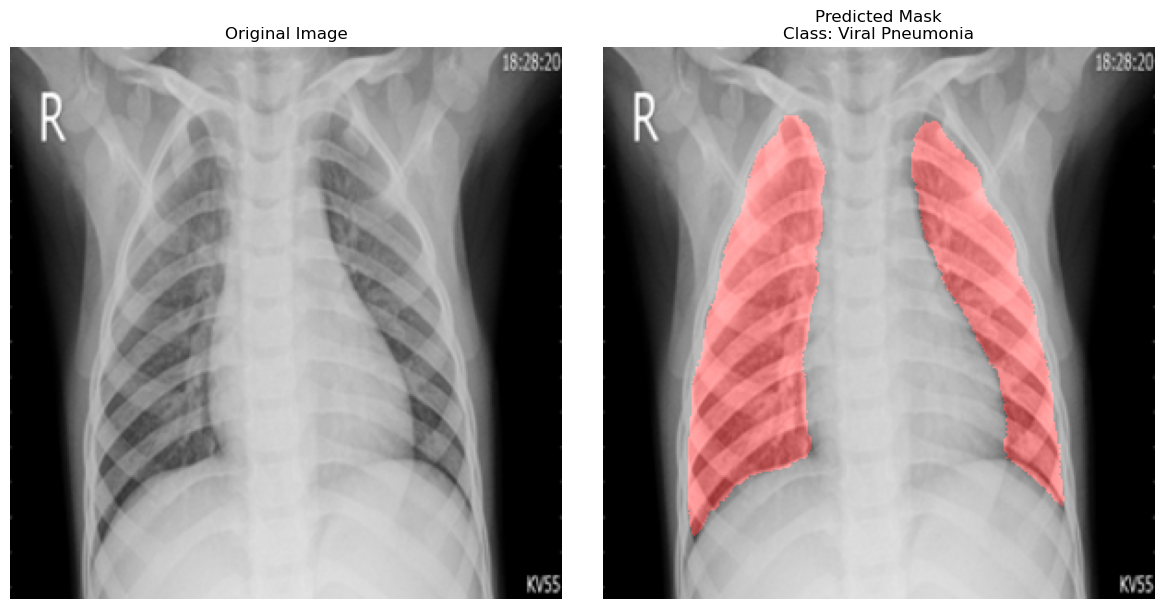

In [32]:
test_image = "COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-2.png"
visualize_predictions(best_model, test_image, class_names=class_names)